In [3]:
technique = "pem"
file_name = "Job Input Form.xlsm"
sheet_name = "Hist. Data"
##Technique to be investigated

In [4]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import numpy as np
import json
import re
import math
std_df = pd.read_excel(file_name, sheet_name = sheet_name)

/Users/linhuaian/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
std_df["Job ID"] = std_df["Job ID"].apply(lambda x: x.lower())
df = std_df.copy()
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("high", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("low", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("res", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("dynamic", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("static", "").replace(" ", ""))

# Using NLP to predict whether technique will detect anomaly
## Create keys and techniques arrays

In [6]:
def array_on_duplicate_keys(ordered_pairs):
    """Convert duplicate keys to one value"""
    d = {}
    for k, v in ordered_pairs:
        v = "yes" if "yes" in str(v).lower() else "no"
        if k in d:
            if d[k] == "yes":
                continue
            else:
                d[k] = v
        else:
            d[k] = v
    return d

In [7]:
techniques = list(map(lambda x: json.loads(x.replace("'", '"'), object_pairs_hook=array_on_duplicate_keys), df["Techniques"].tolist()))
keys = []
for t in techniques:
    keys.extend(list(t.keys()))
keys = list(set(keys))

## Add individual keys and techniques into dataframe, remove original techniques column

In [8]:
technique_count = {}

In [9]:
success_rate_df = df.copy()
for k in keys:
    l = list(map(lambda x: (1 if x[k].lower() == "yes" else 0) if k in x.keys() else None, techniques))
    technique_count[k] = len(list(filter(lambda x: x, l)))
    success_rate_df[k] = l

In [10]:
technique_count
technique_count_perc = {}
for t, c in technique_count.items():
    technique_count_perc[t] = f"{round(c/sum(technique_count.values()) * 100, 2)}"
pd.DataFrame(technique_count_perc, index = technique_count_perc.keys()).to_clipboard()

In [11]:
success_rate_df

,Job ID,Quarter,Analyst(s),Product Name,Test Phase,Test Phase Variant,Time,Failure,Failure Variant,Failure Sub Variant,...,eds,thermalcamera,pfibdelayering,nanoprobing,lvi,kvsem/imaging/bse,stem,tem,sdl,xray
0,cs0020390sg,Q1,"Lim Soon Huat, Celvin Lim, Ho MunYee, Vignesh ...",Bristol,Yield,NaN,NaN,BIST,Bit,NaN,...,NaN,NaN,NaN,1.0,NaN,0.0,NaN,0.0,NaN,NaN
1,cs0020391sg,Q1,"Lim Soon Huat, Vignesh Viswanathan",Bristol,Yield,NaN,NaN,BIST,Bit,NaN,...,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN
2,cs0020460sg,Q2,"Yi-Xuan, Vansath",Lexa,Yield,NaN,NaN,Scan,Delay,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,cs0020510sg,Q1,"Gopi, Yi Xuan, Vasanth",Clayton,REL,Qual,NaN,IOSPEC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cs0020517sg,Q1,Vilson,Kingston,Yield,NaN,NaN,IOSPEC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,cs0027774sg,Q1,"Seah Yi-Xuan,Hu Haoran,Ng Kaihui,Vasanth Somas...",Genesis,CCAR,NaN,NaN,Scan,Delay,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
465,cs0027858sg,Q1,"David Jin Jie,Seah Yi-Xuan",Octo,REL,ERA,T168H,BIST,Bit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
466,cs0027809sg,Q1,Ng Kaihui,Navi33,REL,HTOL,NaN,BIST,Column,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,cs0027765sg,Q1,"David Jin Jie,Ng Kaihui,Vasanth Somasundaram",Genesis,CCAR,NaN,NaN,Scan,Delay,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [12]:
success_rate_df.columns

Index(['Job ID', 'Quarter', 'Analyst(s)', 'Product Name', 'Test Phase',
       'Test Phase Variant', 'Time', 'Failure', 'Failure Variant',
       'Failure Sub Variant', 'Failing Conditions', 'Failure Remarks',
       'FI Success', 'PFA Success', 'Techniques', 'FI Cost', 'PFA Cost',
       'Technique Remarks', 'Date Finished', 'BU', 'Technology Node',
       'Root Cause', 'pem', 'tiva', 'liva', 'layouttracing', 'irem', 'csam',
       'conductiveafm', 'curvetrace', 'pvc', 'diecrackopticalanalysis', 'lvp',
       'lsm', 'opticalinspection', 'eds', 'thermalcamera', 'pfibdelayering',
       'nanoprobing', 'lvi', 'kvsem/imaging/bse', 'stem', 'tem', 'sdl',
       'xray'],
      dtype='object')

In [13]:
selected_features = ['Test Phase',
       'Test Phase Variant', 'Failure', 'Failure Variant',
       'Failure Sub Variant', 'Failing Conditions', 'BU', 'Technology Node', technique]

In [14]:
success_rate_df["Job ID"] = success_rate_df["Job ID"].apply(lambda x: x.lower())
nlp_df = success_rate_df
nlp_df = nlp_df.fillna("")
nlp_df = nlp_df[selected_features]
nlp_df = nlp_df[~nlp_df[technique].isna()]
nlp_df = nlp_df[nlp_df[technique] != ""]
nlp_df[technique] = nlp_df[technique].apply(lambda x: int(x))

In [15]:
X, y = nlp_df.drop([technique], axis = 1), nlp_df[technique]

In [16]:
X.shape

(368, 8)

In [17]:
X.columns

Index(['Test Phase', 'Test Phase Variant', 'Failure', 'Failure Variant',
       'Failure Sub Variant', 'Failing Conditions', 'BU', 'Technology Node'],
      dtype='object')

In [18]:
X

,Test Phase,Test Phase Variant,Failure,Failure Variant,Failure Sub Variant,Failing Conditions,BU,Technology Node
2,Yield,,Scan,Delay,,vmin,dGPU,gf14
4,Yield,,IOSPEC,,,,SCBU,tsmc16
5,CCAR,,Scan,Delay,,,SCBU,tsmc16
7,REL,HTOL,Scan,Delay,,,dGPU,gf14
9,CCAR,,BIST,"Column, Row",,,dGPU,gf14
...,...,...,...,...,...,...,...,...
462,CCAR,,Scan,Delay,,,Server,tsmc7
463,CCAR,,Scan,Delay,,,Client,tsmc7
466,REL,HTOL,BIST,Column,,,dGPU,tsmc6
467,CCAR,,Scan,Delay,,,Server,tsmc7


In [19]:
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X)

In [20]:
smote = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3)
ohe = OneHotEncoder(handle_unknown='ignore')
X_train = ohe.fit_transform(X_train)
try:
    X_train, y_train = smote.fit_resample(X_train, y_train)
except Exception as e:
    print(str(e))
    print("Too little data!")

In [21]:
def print_statistics(y_actual, y_pred, y_prob, m_name):
    print(f"====================={m_name}====================")
    print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
    print(f"precision (macro): {round(skmetrics.precision_score(y_actual, y_pred, average='macro'),5)}")
    print(f"recall (macro): {round(skmetrics.recall_score(y_actual, y_pred, average='macro'),5)}")
    print(f"f1 score (macro): {round(skmetrics.f1_score(y_actual, y_pred, average='macro'),5)}")
    print(f"f1 score of class 1: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=1),5)}")
    print(f"f1 score of class 0: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=0),5)}")
    prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob)
    print(f"pr auc score of class 1: {round(skmetrics.auc(recall, prec),5)}")
    prec_0, recall_0, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob, pos_label=0)
    print(f"pr auc score of class 0: {round(skmetrics.auc(recall_0, prec_0),5)}")
    RocCurveDisplay.from_predictions(
        y_pred,
        y_test,
        name=f" vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{technique} Anomaly Detection {m_name}")
    plt.legend()
    plt.show()
    return skmetrics.accuracy_score(y_actual, y_pred)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn import metrics as skmetrics
m1 = LogisticRegression()
m2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
m3 = RandomForestClassifier(max_depth=2, random_state=0)
m4 = LinearDiscriminantAnalysis()
m5 = AdaBoostClassifier()
models = [m1, m2, m3, m4, m5]

=====================LogisticRegression====================
accuracy: 0.81081
precision (macro): 0.65093
recall (macro): 0.73895
f1 score (macro): 0.67339
f1 score of class 1: 0.88525
f1 score of class 0: 0.46154
pr auc score of class 1: 0.96053
pr auc score of class 0: 0.24818


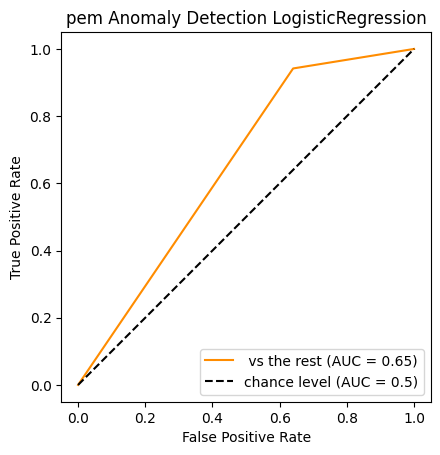

=====================GradientBoostingClassifier====================
accuracy: 0.84685
precision (macro): 0.67792
recall (macro): 0.72901
f1 score (macro): 0.69745
f1 score of class 1: 0.91005
f1 score of class 0: 0.48485
pr auc score of class 1: 0.96024
pr auc score of class 0: 0.28293


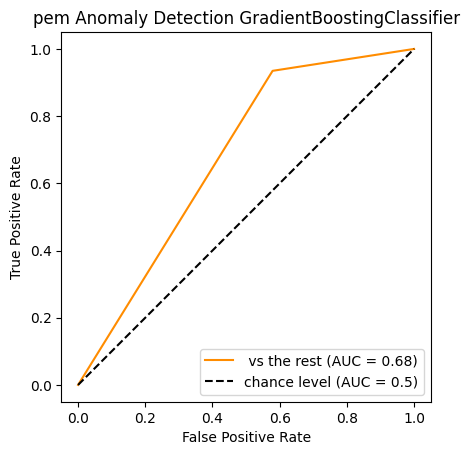

=====================RandomForestClassifier====================
accuracy: 0.76577
precision (macro): 0.60671
recall (macro): 0.68262
f1 score (macro): 0.61825
f1 score of class 1: 0.85556
f1 score of class 0: 0.38095
pr auc score of class 1: 0.95085
pr auc score of class 0: 0.28647


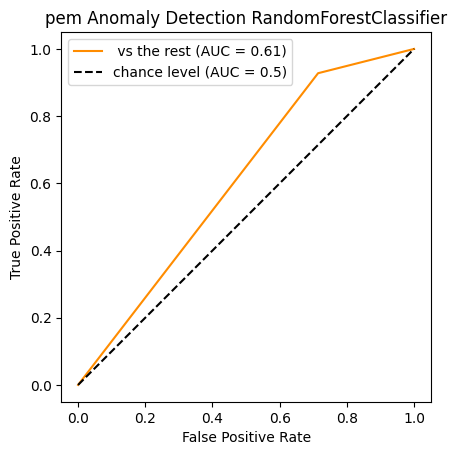

=====================LinearDiscriminantAnalysis====================
accuracy: 0.75676
precision (macro): 0.62587
recall (macro): 0.73859
f1 score (macro): 0.63562
f1 score of class 1: 0.84571
f1 score of class 0: 0.42553
pr auc score of class 1: 0.95941
pr auc score of class 0: 0.21354


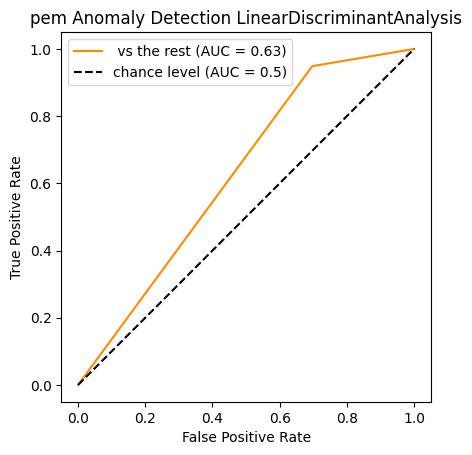

=====================AdaBoostClassifier====================
accuracy: 0.85586
precision (macro): 0.68996
recall (macro): 0.73417
f1 score (macro): 0.70789
f1 score of class 1: 0.91579
f1 score of class 0: 0.5
pr auc score of class 1: 0.96124
pr auc score of class 0: 0.28258


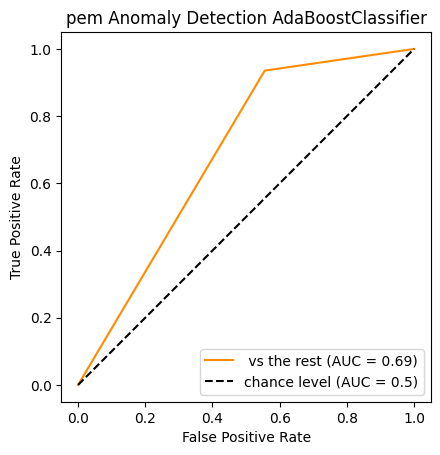

In [23]:
best_model = None
highest_score = 0
for model in models:
    clf = model.fit(X_train.toarray(), y_train)
    y_pred = clf.predict(ohe.transform(X_test))
    train_y_pred = clf.predict(X_train.toarray())
    auc_score = print_statistics(y_test, y_pred, np.round(y_pred), type(model).__name__)
    if auc_score > highest_score:
        best_model = clf
        highest_score = auc_score